# 📊 Implementasi Deep Learning

**Judul:** Implementasi Convolutional Neural Network dengan Arsitektur VGG16 untuk Klasifikasi Penyakit Daun Tanaman Jeruk

- Menggunakan Dataset Penyakit Daun Jeruk (asli) di augmentasikan


In [7]:
# ====================================
# LANGKAH 1: Ekstrak Dataset Asli dari Lokal
# ====================================
import zipfile, os

zip_path = r'D:\Coba DL\Dataset Penyakit Daun Jeruk.zip'  # Ganti sesuai lokasi zip kamu
extract_path = './dataset_ori'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Path ke folder gambar
base_path = os.path.join(extract_path, 'Citrus Leaf Disease Image')

In [8]:
# ====================================
# LANGKAH 2: Hitung Jumlah Gambar per Kelas
# ====================================
class_counts = {cls: len(os.listdir(os.path.join(base_path, cls))) for cls in os.listdir(base_path)}
print("Jumlah gambar per kelas:", class_counts)

Jumlah gambar per kelas: {'Black spot': 250, 'Canker': 250, 'Greening': 250, 'Healthy': 250, 'Melanose': 250}


In [9]:
# ====================================
# LANGKAH 3: Augmentasi Dataset agar Seimbang (250 per kelas)
# ====================================
#%pip install Pillow
#%pip install scipy

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np

aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

target_count = 250

for class_name, count in class_counts.items():
    class_dir = os.path.join(base_path, class_name)
    images = os.listdir(class_dir)

    i = 0
    while count + i < target_count:
        img_name = images[i % len(images)]
        img_path = os.path.join(class_dir, img_name)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        aug_iter = aug.flow(image, batch_size=1, save_to_dir=class_dir,
                            save_prefix='aug', save_format='jpg')
        next(aug_iter)
        i += 1

print("✅ Augmentasi selesai!")


✅ Augmentasi selesai!


In [10]:
# ====================================
# LANGKAH 4: Data Generator (Training & Validation)
# ====================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())

Found 1000 images belonging to 5 classes.
Found 250 images belonging to 5 classes.


In [11]:
# ====================================
# LANGKAH 5: Build dan Train Model
# ====================================
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

def build_model():
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(len(class_names), activation='softmax')
    ])
    return model

model = build_model()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Training model
epochs = 50
model.fit(train_generator, validation_data=val_generator, epochs=epochs)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 253s 8s/step - accuracy: 0.2759 - loss: 1.5904 - val_accuracy: 0.5240 - val_loss: 1.2161
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 239s 8s/step - accuracy: 0.4769 - loss: 1.2467 - val_accuracy: 0.6600 - val_loss: 1.0163
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 240s 8s/step - accuracy: 0.5459 - loss: 1.0763 - val_accuracy: 0.7560 - val_loss: 0.8872
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 237s 8s/step - accuracy: 0.5924 - loss: 0.9425 - val_accuracy: 0.6960 - val_loss: 0.8179
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 245s 8s/step - accuracy: 0.5995 - loss: 0.9043 - val_accuracy: 0.6920 - val_loss: 0.7749
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 254s 7s/step - accuracy: 0.6580 - loss: 0.8368 - val_accuracy: 0.7560 - val_loss: 0.7149
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 239s 8s/step - accuracy: 0.6510 - loss: 0.7886 - val_accuracy: 0.7880 - val_loss: 0.6767
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 231s 7s/step - accuracy: 0.7105 - loss: 0.7332 - val_accuracy: 0.7400 - v

In [12]:
# ====================================
# LANGKAH 6: Evaluasi dan Prediksi
# ====================================
import numpy as np

def extract_predictions(model, generator):
    generator.reset()
    all_images = []
    all_true_labels = []
    all_pred_labels = []

    for _ in range(len(generator)):
        imgs, labels = next(generator)
        preds = model.predict(imgs)
        all_images.extend(imgs)
        all_true_labels.extend(np.argmax(labels, axis=1))
        all_pred_labels.extend(np.argmax(preds, axis=1))

    return np.array(all_images), np.array(all_true_labels), np.array(all_pred_labels)

img, true_lbl, pred_lbl = extract_predictions(model, val_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step



=== Model - Dataset Augmentasi ===
              precision    recall  f1-score   support

  Black spot       0.68      0.76      0.72        50
      Canker       0.98      0.86      0.91        50
    Greening       0.84      0.72      0.77        50
     Healthy       0.82      0.94      0.88        50
    Melanose       1.00      1.00      1.00        50

    accuracy                           0.86       250
   macro avg       0.86      0.86      0.86       250
weighted avg       0.86      0.86      0.86       250



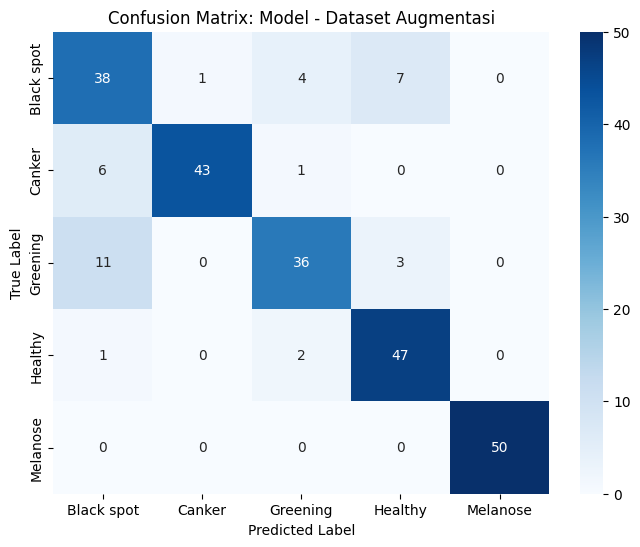

In [16]:
# ====================================
# LANGKAH 7: Confusion Matrix dan Classification Report
# ====================================
#%pip install scikit-learn
#%pip install seaborn

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def print_evaluation_metrics(true_labels, pred_labels, label_names, title=""):
    print(f"\n=== {title} ===")
    print(classification_report(true_labels, pred_labels, target_names=label_names))

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

print_evaluation_metrics(true_lbl, pred_lbl, class_names, title="Model - Dataset Augmentasi")


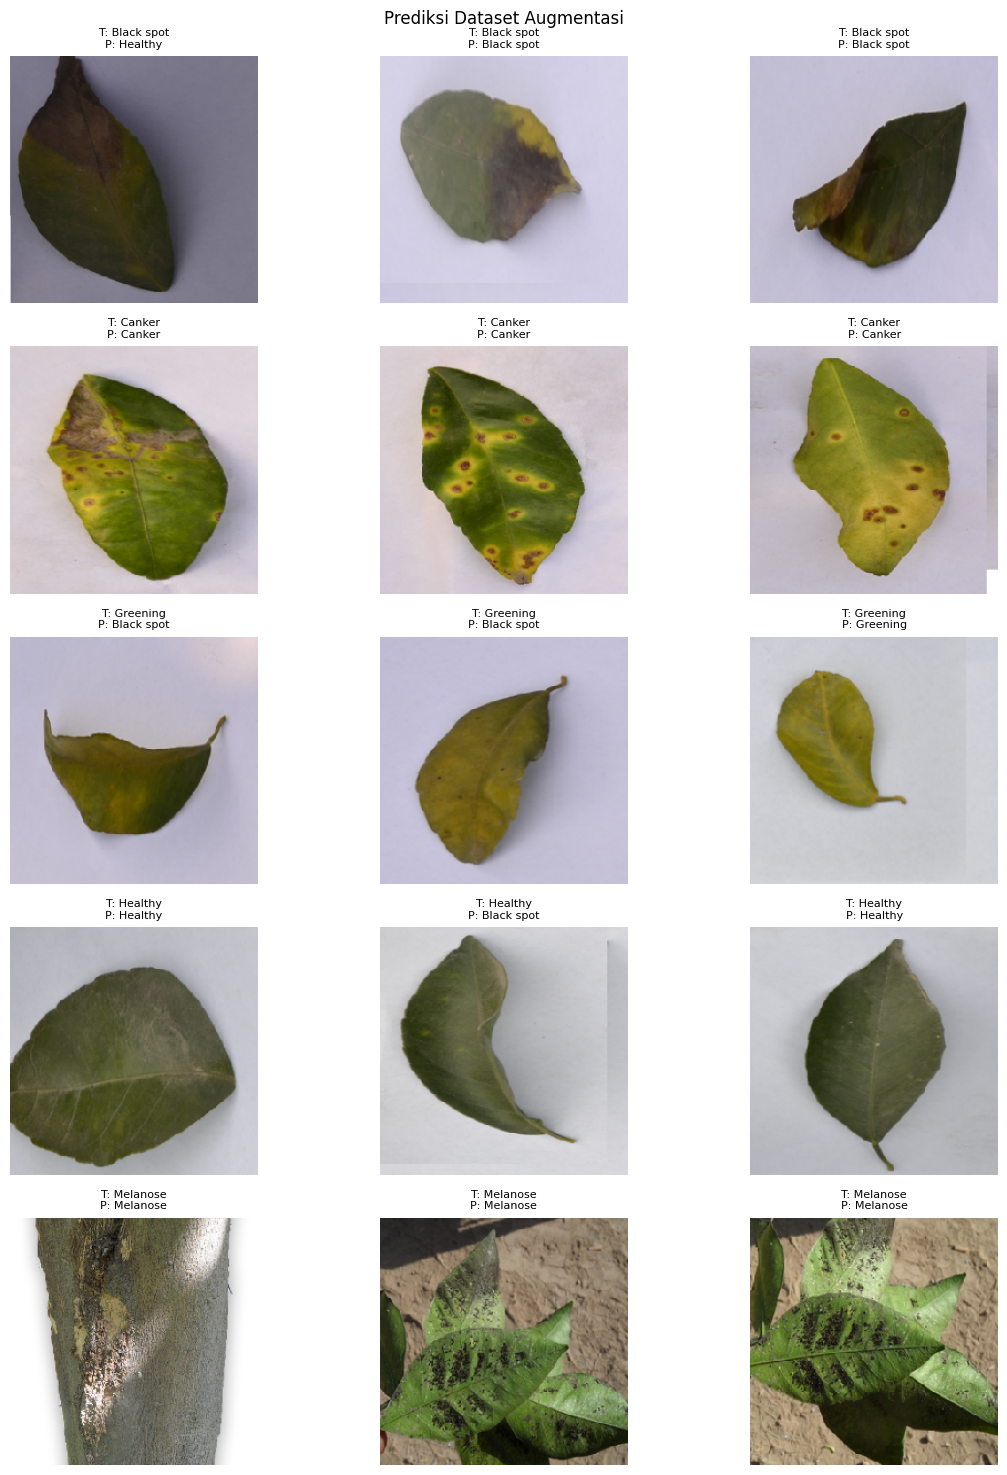

In [17]:
# ====================================
# LANGKAH 8: Visualisasi Prediksi
# ====================================
num_samples_per_class = 3

def plot_predictions(images, true_labels, pred_labels, class_names, title):
    plt.figure(figsize=(12, len(class_names) * 3))
    plot_idx = 1
    for class_idx, class_name in enumerate(class_names):
        indices = np.where(true_labels == class_idx)[0][:num_samples_per_class]
        for i in indices:
            plt.subplot(len(class_names), num_samples_per_class, plot_idx)
            plt.imshow(images[i])
            plt.axis('off')
            t_label = class_names[true_labels[i]]
            p_label = class_names[pred_labels[i]]
            plt.title(f"T: {t_label}\nP: {p_label}", fontsize=8)
            plot_idx += 1
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_predictions(img, true_lbl, pred_lbl, class_names, "Prediksi Dataset Augmentasi")